# 1. Introduction

This notebook presents a machine learning project focused on predicting the average Center of Pressure (COP) velocity per frame using radar data. The primary objective is to develop a model that can accurately estimate the COP speed from sequences of radar Range-Doppler Maps (RDMs), which is essential for analyzing balance and stability in human movement.

By leveraging a combination of Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks, the model captures both spatial and temporal features from the radar data. The CNN layers extract meaningful spatial representations from individual RDM frames, while the LSTM layers model the temporal dependencies across frames.

The dataset comprises synchronized radar data and force plate measurements collected from participants performing balance tasks. The radar data provides RDM frames over time, and the force plate data offers ground truth COP velocities. This notebook guides you through the steps of loading and preprocessing the data, defining the neural network model, training the model, and evaluating its performance.

The successful prediction of COP velocity from radar data has significant implications in fields such as biomechanics, rehabilitation, and sports science. It enables non-invasive monitoring of balance and stability, which can aid in fall prevention strategies and the assessment of motor functions.

**Key Components:**

- **Data Loading:** Importing radar RDM sequences and corresponding COP velocity measurements.
- **Data Preprocessing:** Normalizing data and handling variable sequence lengths for efficient model training.
- **Model Definition:** Building a CNN-LSTM model tailored for sequential speed prediction.
- **Training and Evaluation:** Implementing training loops, loss functions, and performance metrics to optimize the model.
- **Visualization:** Analyzing model predictions against true values to assess accuracy.

**Expected Outcomes:**

- A trained machine learning model capable of predicting per-frame COP velocities from radar data.
- Insights into the relationship between radar signal patterns and human balance dynamics.
- A foundation for further research and development in radar-based motion analysis.

Let's embark on this journey to bridge the gap between radar sensing technology and human movement analysis through machine learning.

# 2. Setup and Configuration

### Import Libraries and Classes

In [1]:
from RADARDataCapture import FMCWRADARDataCapture
from MOCAPDataCapture import MOCAPDataCapture
from FPDataCapture import FPDataCapture
from StableRdmDataset import StableRdmDataset
import h5py
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from datetime import datetime
import statistics
from matplotlib import animation
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch import optim
from datetime import datetime
from COPSpeedPredictionByRDMFrameCNNLSTMModel import COPSpeedPredictionByRDMFrameCNNLSTMModel


### Set Random Seeds for Reproducability

In [2]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 3. Data Loading

In [3]:
import os
import random
from torch.utils.data import DataLoader
from ByFrameStableRdmDataset import ByFrameStableRdmDataset  # Import the new dataset class

# Define the root directory and event CSV path
root_dir = '/Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch'
event_csv = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv"

# Get all folders and shuffle them randomly
all_folders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
random.seed(42)  # For reproducibility
random.shuffle(all_folders)

# Calculate the number of folders for each set
num_total_folders = len(all_folders)
num_train_folders = int(num_total_folders * 0.7)
num_val_folders = int(num_total_folders * 0.15)
num_test_folders = num_total_folders - (num_train_folders + num_val_folders)

# Split the folders into train, validation, and test sets
train_folders = all_folders[:num_train_folders]
val_folders = all_folders[num_train_folders:num_train_folders + num_val_folders]
test_folders = all_folders[num_train_folders + num_val_folders:]

print(f'Total folders: {num_total_folders}')
print(f'Train folders ({len(train_folders)}): {train_folders}')
print(f'Validation folders ({len(val_folders)}): {val_folders}')
print(f'Test folders ({len(test_folders)}): {test_folders}')

# Define the setup_loaders function
def setup_loaders(root_dir, event_csv, folders, batch_size=32):
    datasets = {}
    loaders = {}
    
    for phase in ['train', 'val', 'test']:
        dataset = ByFrameStableRdmDataset(root_dir, event_csv, folders[phase])
        shuffle = True if phase == 'train' else False
        loader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            collate_fn=ByFrameStableRdmDataset.collate_fn
        )
        datasets[phase] = dataset
        loaders[phase] = loader
    return loaders, datasets

# Assign folders to each data split
folders = {
    'train': train_folders,
    'val': val_folders,
    'test': test_folders
}

# Create the DataLoaders and Datasets
loaders, datasets = setup_loaders(root_dir, event_csv, folders, batch_size=32)
train_loader = loaders['train']
val_loader = loaders['val']
test_loader = loaders['test']

print(f'Training dataset size: {len(datasets["train"])} samples')
print(f'Validation dataset size: {len(datasets["val"])} samples')
print(f'Test dataset size: {len(datasets["test"])} samples')


Total folders: 15
Train folders (10): ['13', '22', '12', '10', '24', '18', '08', '03', '14', '04']
Validation folders (2): ['05', '16']
Test folders (3): ['01', '02', '15']
Invalid time range for tx 1
tx 1 not found in avg_COP_per_frame_dict for capture 12_MNTRR_RR_V1.
Invalid time range for tx 1
Invalid time range for tx 1
Invalid time range for tx 1
No data available for frame 103 in tx 1.
No data available for frame 103 in tx 1.
No data available for frame 103 in tx 1.
Radar file not found: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/24/24_MNTRR_RR_V1_channel1_tx2.npy
Radar file not found: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/24/24_MNTRR_RR_V1_channel2_tx2.npy
Radar file not found: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/24/24_MNTRR_RR_V1_channel3_tx2.npy
Radar file not found: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/24/24_MNTRR_RR_V1_channel4_tx2.npy
No data available for frame 86 in tx 1.
No data available for frame 86 in tx 1.
No data available f

# ML 

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
for batch_data, batch_labels, batch_lengths, _ in train_loader:
    print(f"batch_data.shape: {batch_data.shape}")
    # Expected shape: [batch_size, seq_len, num_channels, height, width]
    # Move data to device
    batch_data = batch_data.to(device)
    # ...


batch_data.shape: torch.Size([32, 107, 1, 23, 13])
batch_data.shape: torch.Size([32, 110, 1, 23, 13])
batch_data.shape: torch.Size([32, 109, 1, 23, 13])
batch_data.shape: torch.Size([32, 111, 1, 23, 13])
batch_data.shape: torch.Size([32, 110, 1, 23, 13])
batch_data.shape: torch.Size([32, 106, 1, 23, 13])
batch_data.shape: torch.Size([32, 109, 1, 23, 13])
batch_data.shape: torch.Size([32, 123, 1, 23, 13])
batch_data.shape: torch.Size([32, 107, 1, 23, 13])
batch_data.shape: torch.Size([32, 108, 1, 23, 13])
batch_data.shape: torch.Size([32, 108, 1, 23, 13])
batch_data.shape: torch.Size([32, 105, 1, 23, 13])
batch_data.shape: torch.Size([32, 109, 1, 23, 13])
batch_data.shape: torch.Size([32, 123, 1, 23, 13])
batch_data.shape: torch.Size([32, 110, 1, 23, 13])
batch_data.shape: torch.Size([32, 123, 1, 23, 13])
batch_data.shape: torch.Size([32, 104, 1, 23, 13])
batch_data.shape: torch.Size([32, 111, 1, 23, 13])
batch_data.shape: torch.Size([32, 123, 1, 23, 13])
batch_data.shape: torch.Size([3

In [32]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
num_channels = 1  # Since radar data is single-channel
hidden_dim = 128
model = COPSpeedPredictionByRDMFrameCNNLSTMModel(num_channels=num_channels, hidden_dim=hidden_dim)
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_data, batch_labels, batch_lengths, _ in train_loader:
        # Move data to device
        batch_data = batch_data.to(device)  # Shape: [batch_size, seq_len, num_channels, height, width]
        batch_labels = batch_labels.to(device)
        batch_lengths = batch_lengths.to(device)
        
        # Forward pass
        outputs = model(batch_data)
        
        # Mask padded positions
        max_seq_len = outputs.size(1)
        mask = torch.arange(max_seq_len).unsqueeze(0) < batch_lengths.unsqueeze(1)
        mask = mask.to(device)
        
        # Apply mask to outputs and labels
        outputs = outputs * mask.float()
        batch_labels = batch_labels * mask.float()
        
        # Compute loss
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch [1/10], Loss: 0.8363
Epoch [2/10], Loss: 0.7738
Epoch [3/10], Loss: 0.7219
Epoch [4/10], Loss: 0.7094
Epoch [5/10], Loss: 0.7152
Epoch [6/10], Loss: 0.7064
Epoch [7/10], Loss: 0.7080
Epoch [8/10], Loss: 0.7098
Epoch [9/10], Loss: 0.7047
Epoch [10/10], Loss: 0.6950


Validation

In [30]:
# Validation loop
model.eval()
with torch.no_grad():
    total_val_loss = 0.0
    for batch_data, batch_labels, batch_lengths, _ in val_loader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        batch_lengths = batch_lengths.to(device)
        
        outputs = model(batch_data)
        
        # Mask padded positions
        max_seq_len = outputs.size(1)
        mask = torch.arange(max_seq_len).unsqueeze(0) < batch_lengths.unsqueeze(1)
        mask = mask.to(device)
        
        # Apply mask to outputs and labels
        outputs = outputs * mask.float()
        batch_labels = batch_labels * mask.float()
        
        # Compute loss
        loss = criterion(outputs, batch_labels)
        total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Validation Loss: {avg_val_loss:.4f}')


Validation Loss: 0.7103


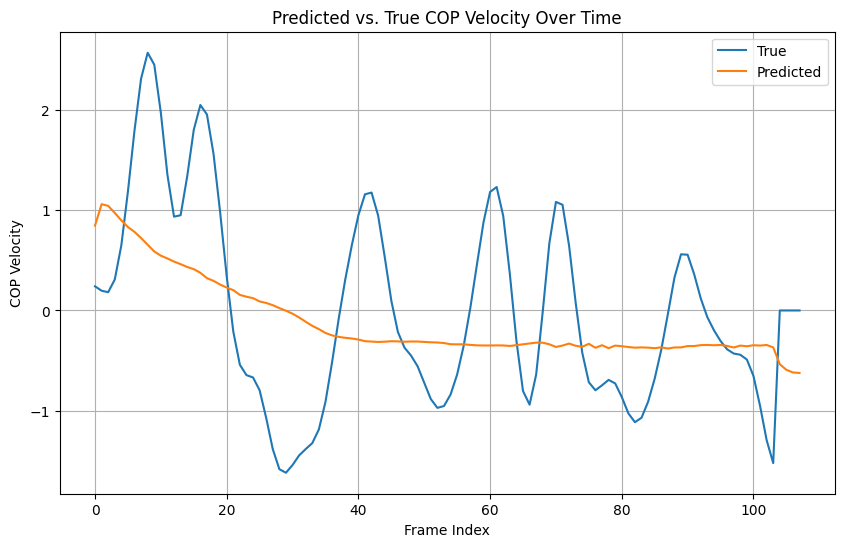

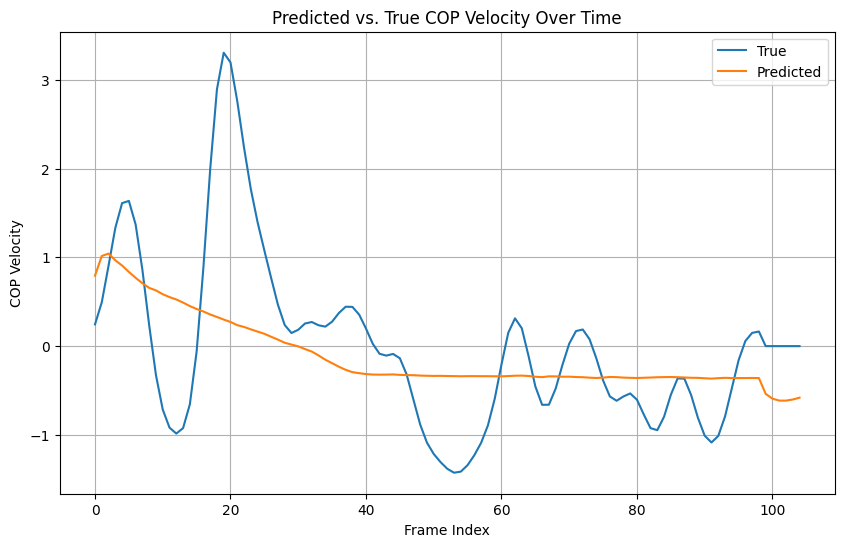

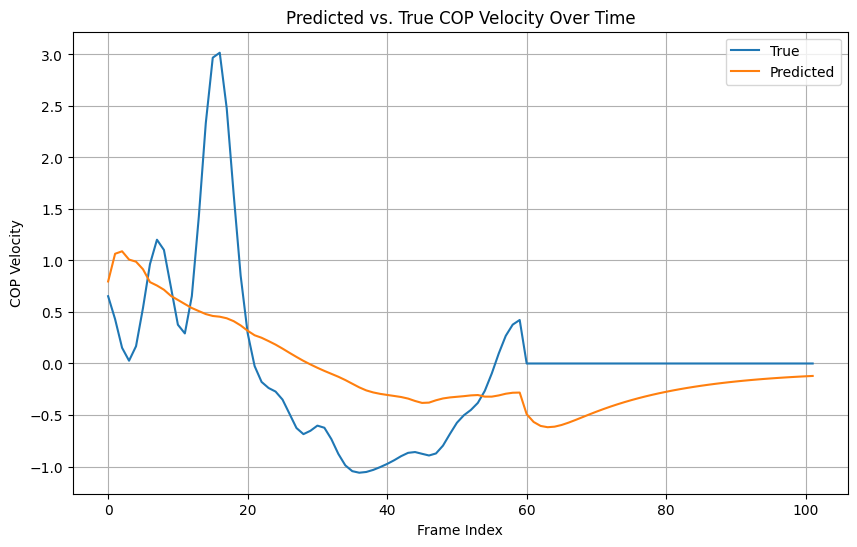

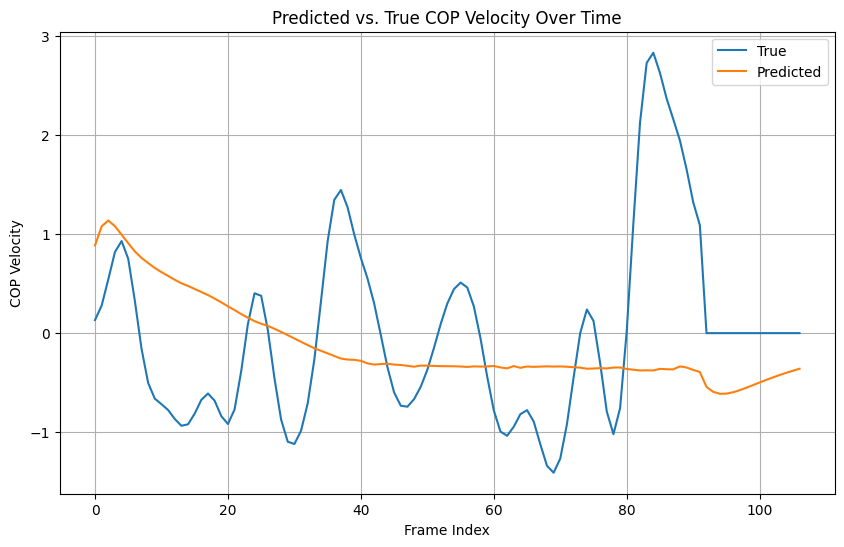

IndexError: index 20 is out of bounds for axis 0 with size 20

<Figure size 1000x600 with 0 Axes>

In [33]:
# Assuming model and data are on the appropriate device
model.eval()
with torch.no_grad():
    for batch_data, batch_labels, batch_lengths, _ in val_loader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        outputs = model(batch_data)
        # Apply mask if necessary
        # Move data to CPU and convert to numpy
        outputs_np = outputs.cpu().numpy()
        batch_labels_np = batch_labels.cpu().numpy()
        # Plotting
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.plot(batch_labels_np[20], label='True')
        plt.plot(outputs_np[20], label='Predicted')
        plt.xlabel('Frame Index')
        plt.ylabel('COP Velocity')
        plt.title('Predicted vs. True COP Velocity Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()



# 4. Exploratory Data Analysis (EDA)

In [9]:
print(f"Number of samples in the training dataset: {len(datasets['train'])}")

Number of samples in the training dataset: 712


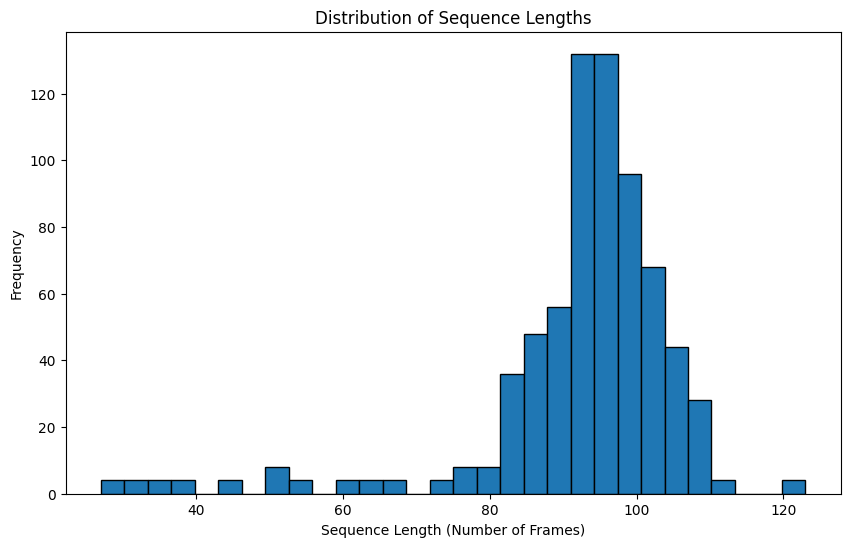

In [10]:
sequence_lengths = [metadata['n_frames'] for metadata in datasets['train'].metadata]

plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=30, edgecolor='k')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length (Number of Frames)')
plt.ylabel('Frequency')
plt.show()


COP Velocities

Total number of COP velocity measurements: 65672
Mean COP velocity: 74.6036
Median COP velocity: 59.1630
Standard deviation of COP velocity: 67.9064


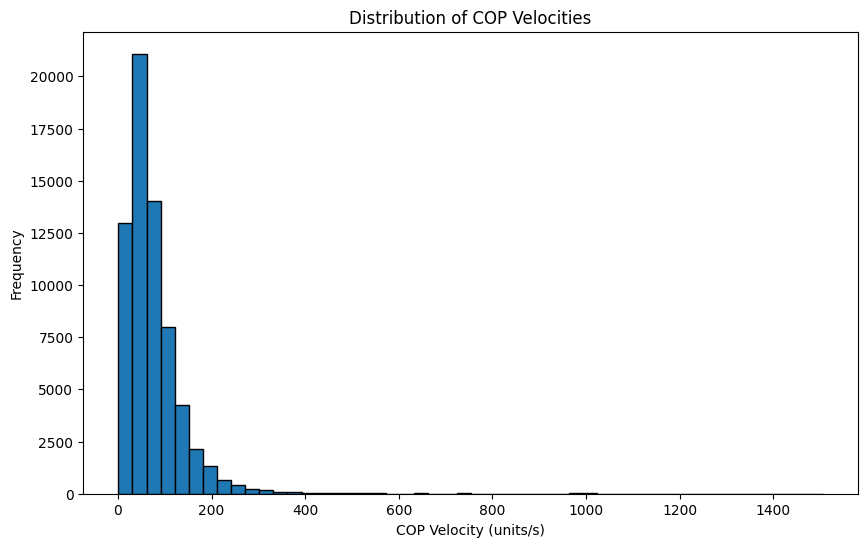

In [11]:
# Flatten all COP velocities into a single array
all_cop_velocities = np.concatenate(datasets['train'].labels)

print(f"Total number of COP velocity measurements: {len(all_cop_velocities)}")
print(f"Mean COP velocity: {np.mean(all_cop_velocities):.4f}")
print(f"Median COP velocity: {np.median(all_cop_velocities):.4f}")
print(f"Standard deviation of COP velocity: {np.std(all_cop_velocities):.4f}")

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(all_cop_velocities, bins=50, edgecolor='k')
plt.title('Distribution of COP Velocities')
plt.xlabel('COP Velocity (units/s)')
plt.ylabel('Frequency')
plt.show()


Vizualize Radar Dataset

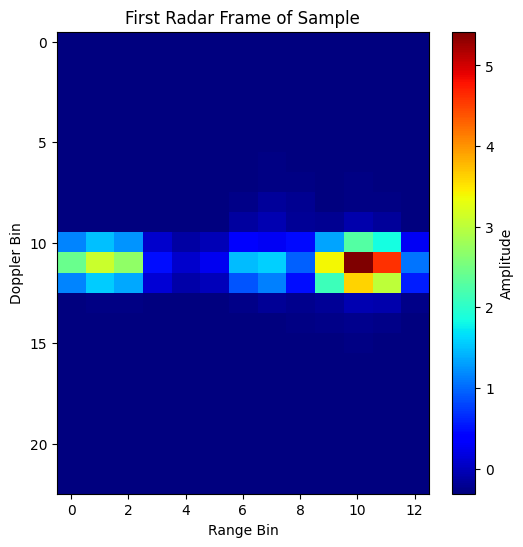

In [14]:
# Get a sample from the dataset
sample_data, sample_label, _, sample_metadata = datasets['train'][5]

# Extract the radar data and label
radar_sequence = sample_data  # Shape: [sequence_length, height, width]
cop_velocities = sample_label  # Shape: [sequence_length]

# Visualize the first radar frame
first_frame = radar_sequence[0].squeeze()  # [height, width]

plt.figure(figsize=(6, 6))
plt.imshow(first_frame, cmap='jet', aspect='auto')
plt.title('First Radar Frame of Sample')
plt.colorbar(label='Amplitude')
plt.xlabel('Range Bin')
plt.ylabel('Doppler Bin')
plt.show()


Viz mutliple Radar

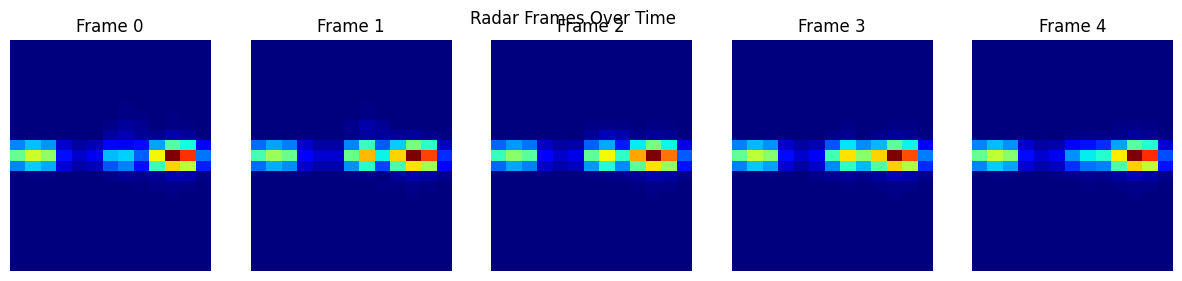

In [17]:
# Select frames to visualize
num_frames_to_plot = min(5, radar_sequence.shape[0])

fig, axes = plt.subplots(1, num_frames_to_plot, figsize=(15, 3))
for i in range(num_frames_to_plot):
    axes[i].imshow(radar_sequence[i].squeeze(), cmap='jet', aspect='auto')
    axes[i].set_title(f'Frame {i}')
    axes[i].axis('off')

plt.suptitle('Radar Frames Over Time')
plt.show()


Plot COP Velocity Sequences

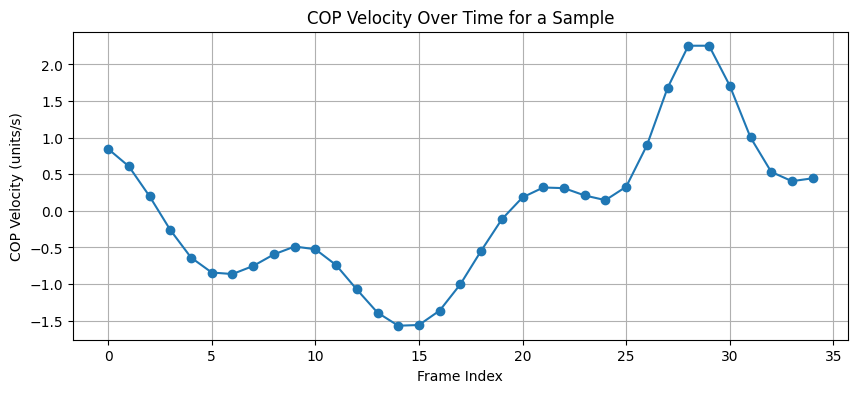

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(cop_velocities, marker='o')
plt.title('COP Velocity Over Time for a Sample')
plt.xlabel('Frame Index')
plt.ylabel('COP Velocity (units/s)')
plt.grid(True)
plt.show()


Compare Radar Activity with COP Velocity

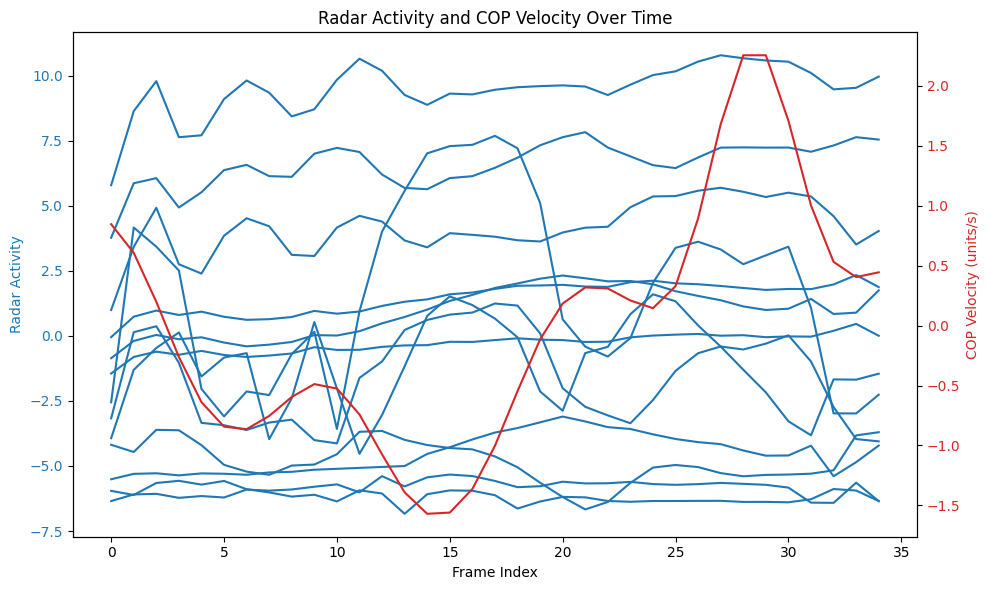

In [20]:
# Sum radar amplitudes over range and doppler bins for each frame
radar_activity = radar_sequence.sum(axis=(1, 2))

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Frame Index')
ax1.set_ylabel('Radar Activity', color=color)
ax1.plot(radar_activity, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Radar Activity and COP Velocity Over Time')

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('COP Velocity (units/s)', color=color)
ax2.plot(cop_velocities, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


In [21]:
high_velocity_threshold = np.percentile(all_cop_velocities, 90)
low_velocity_threshold = np.percentile(all_cop_velocities, 10)

print(f"High velocity threshold (90th percentile): {high_velocity_threshold:.4f}")
print(f"Low velocity threshold (10th percentile): {low_velocity_threshold:.4f}")

# Count frames above and below thresholds
num_high_velocity = np.sum(all_cop_velocities > high_velocity_threshold)
num_low_velocity = np.sum(all_cop_velocities < low_velocity_threshold)

print(f"Number of high-velocity frames: {num_high_velocity}")
print(f"Number of low-velocity frames: {num_low_velocity}")


High velocity threshold (90th percentile): 140.2480
Low velocity threshold (10th percentile): 21.6729
Number of high-velocity frames: 6568
Number of low-velocity frames: 6568


In [ ]:
radar_activities = []
cop_velocities_all = []

for data, labels, _, _ in datasets['train']:
    radar_activity = data.sum(axis=(1, 2))  # Sum over height and width for each frame
    radar_activities.extend(radar_activity)
    cop_velocities_all.extend(labels)

radar_activities = np.array(radar_activities)
cop_velocities_all = np.array(cop_velocities_all)


Correlation between radar activity and COP velocity: 0.0319


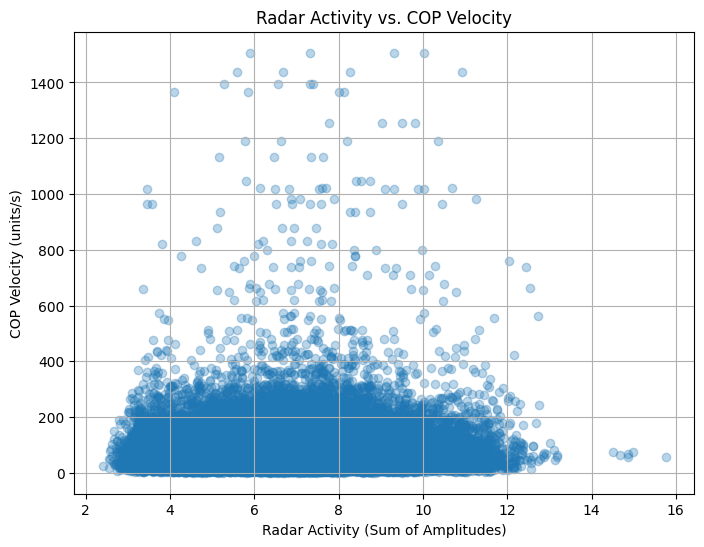

In [ ]:
correlation = np.corrcoef(radar_activities, cop_velocities_all)[0, 1]
print(f"Correlation between radar activity and COP velocity: {correlation:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(radar_activities, cop_velocities_all, alpha=0.3)
plt.title('Radar Activity vs. COP Velocity')
plt.xlabel('Radar Activity (Sum of Amplitudes)')
plt.ylabel('COP Velocity (units/s)')
plt.grid(True)
plt.show()


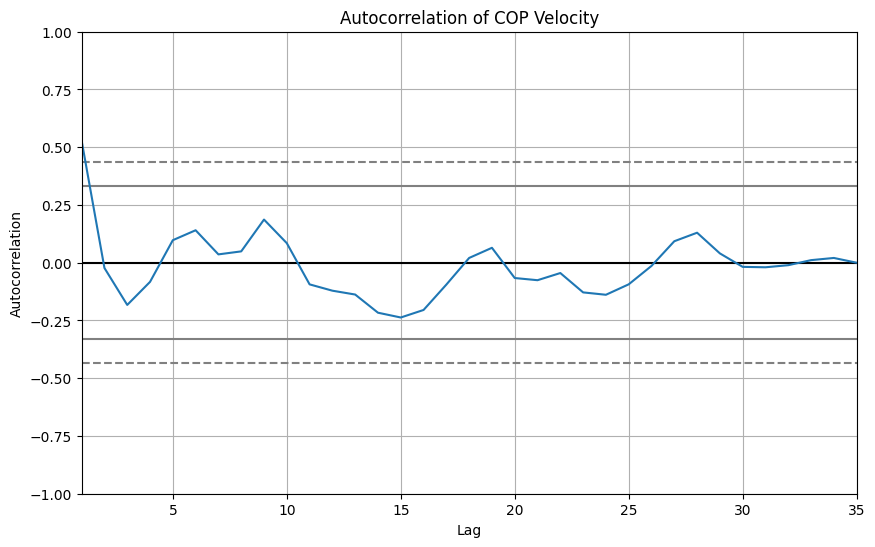

In [ ]:
from pandas.plotting import autocorrelation_plot

cop_velocity_series = pd.Series(cop_velocities)

plt.figure(figsize=(10, 6))
autocorrelation_plot(cop_velocity_series)
plt.title('Autocorrelation of COP Velocity')
plt.show()


COP Historgram by Participant

In [ ]:
# participant_ids = [metadata['participant_id'] for metadata in datasets['train'].metadata]
# unique_participants = set(participant_ids)
# print(f"Participants in training dataset: {unique_participants}")

# # Analyze COP velocities for each participant
# for participant_id in unique_participants:
#     indices = [i for i, pid in enumerate(participant_ids) if pid == participant_id]
#     participant_cop_velocities = np.concatenate([datasets['train'].labels[i] for i in indices])
    
#     plt.figure(figsize=(10, 6))
#     plt.hist(participant_cop_velocities, bins=50, edgecolor='k')
#     plt.title(f'COP Velocity Distribution for Participant {participant_id}')
#     plt.xlabel('COP Velocity (units/s)')
#     plt.ylabel('Frequency')
#     plt.show()


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[1, 3520, 23, 13] to have 1 channels, but got 3520 channels instead

Validation